In [2]:
!pip install -U langchain langchain-community replicate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/dinarfa/capstone-project-ibm/refs/heads/main/reviews_data.csv"
df = pd.read_csv(url)
# df.shape
# Bersihkan data: hapus review kosong dan duplikat
df = df.dropna(subset=['Review']).drop_duplicates(subset=['Review'])
df.head(20)


,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...
5,Alyssa,"Sunnyvale, TX","Reviewed Sept. 14, 2023",1.0,We had to correct them on our order 3 times. T...,['No Images']
6,ken,"Spring Hill, FL","Reviewed Sept. 8, 2023",1.0,I have tried Starbucks several different times...,['No Images']
7,Nikki,"Asheville, NC","Reviewed Aug. 25, 2023",1.0,Starbucks near me just launched new fall foods...,['No Images']
8,Alex,"Reisterstown, MD","Reviewed Aug. 5, 2023",1.0,"I ordered online for the Reisterstown Rd, St T...",['No Images']
9,Sunny,"Zionville, Other","Reviewed Aug. 4, 2023",1.0,Staff at the Smythe St. Superstore location in...,['No Images']


In [4]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata

#Set the API Token
api_token = userdata.get('REPLICATE_API')

os.environ['REPLICATE_API_TOKEN'] = api_token

# Model Setup
model = "ibm-granite/granite-3.3-8b-instruct"

output = Replicate(
    model = model,
    replicate_api_token = api_token
)


In [6]:
# Ambil 20 review teratas (bisa lebih)
reviews = df['Review'].dropna().head(20).tolist()

# Loop per batch isi 5 review (biar tidak kepotong karena max tokens)
for i in range(0, len(reviews), 5):
    batch = reviews[i:i+5]

    review_text = "\n".join([f"Review #{j+1}: {text}" for j, text in enumerate(batch)])

    prompt = f"""
    Analyze each Starbucks review in two steps.

    Step 1 — Classify the sentiment:
    Label as "Positive", "Negative", or "Mixed".

    Use "Mixed" only if the review includes both clear praise and complaint about Starbucks' drinks, staff, payment, etc.
    Do NOT label as Mixed if contrast only reflects the reviewer's emotion or effort (e.g., “I tried to be nice”).
    Be attentive to contrast words like "but", "although", "despite", "even though", "however", "if only", "though".
    These may indicate Mixed sentiment only if both sides refer to Starbucks experience.
    If the review only contains complaint (even politely), label it Negative.

    Step 2 — Identify focus areas:
    Choose one or more from: employee, product, payment, ambience, cleanliness, waiting time, price.

    Use this output format:
    Review #[number]: [Sentiment] — [Short explanation] | Focus: [keywords]

    Keep explanation brief and focused. Use 8–15 words max.

    Examples:
    Review #1: Mixed — Great coffee, rude cashier | Focus: product, employee
    Review #2: Positive — Fast service, tasty drinks | Focus: employee, product
    Review #3: Negative — Long wait, dirty tables | Focus: waiting time, cleanliness
    Review #4: Mixed — Easy payment, bad drinks | Focus: payment, product

    {review_text}
    """

    parameters = {
        "top_k": 5,
        "top_p": 0.85,
        "max_tokens": 400,
        "min_tokens": 30,
        "random_seed": 42,
        "repetition_penalty": 1.2,
        "stopping_criteria": "length",
        "stopping_sequence": "\n"
    }

    # Invoke the model with prompt
    response = output.invoke(prompt, parameters=parameters)

    # Print the response
    print(f"\nGranite Model Response for batch {i//5 + 1}:\n")
    print(response)



Granite Model Response for batch 1:

Review #1: Positive — Outstanding customer service by Amber and LaDonna | Focus: employee
Review #2: Positive — Exceptional customer service by barista at Altamonte Springs location | Focus: employee
Review #3: Positive — Billy provided excellent, quick service under pressure | Focus: employee
Review #4: Positive — Dillon kindly covered drinks when card failed | Focus: employee
Review #5: Positive — Free hot water provided consistently, great coffee | Focus: employee, product

Granite Model Response for batch 2:

Review #1: Negative — Rude cashier, racist manager accusation | Focus: employee
Review #2: Negative — Dirt-tasting coffee, dislike of Starbucks | Focus: product
Review #3: Negative — Out-of-stock new items, poor product management | Focus: product
Review #4: Negative — Wrong drink size, customer dissatisfaction | Focus: product
Review #5: Negative — Uncommunicative staff, poor Americano quality | Focus: employee, product

Granite Model Res

In [ ]:
# Running ini jika ingin mengklasifikasikan semua data (800an baris)
import pandas as pd

# Load data
url = "https://raw.githubusercontent.com/dinarfa/capstone-project-ibm/refs/heads/main/reviews_data.csv"
df = pd.read_csv(url)
reviews = df['Review'].dropna().drop_duplicates().tolist()

# Konfigurasi
batch_size = 30
all_outputs = []

for start in range(0, len(reviews), batch_size):
    batch = reviews[start:start + batch_size]
    review_text = "\n".join([f"Review #{start + i + 1}: {text}" for i, text in enumerate(batch)])

    prompt = f"""
    Analyze each Starbucks review in two steps.

    Step 1 — Classify the sentiment:
    Label as "Positive", "Negative", or "Mixed".

    Use "Mixed" only if the review includes both clear praise and complaint about Starbucks (e.g. drinks, staff, payment).
    Do NOT label as Mixed if contrast only reflects the reviewer's emotion or effort (e.g., “I tried to be nice”).
    Be attentive to contrast words like "but", "although", "despite", "even though", "however", "if only", "though".
    These may indicate Mixed sentiment only if both sides refer to Starbucks experience.
    If the review only contains complaint (even politely), label it Negative.

    Step 2 — Identify focus areas:
    Choose one or more from: employee, product, payment, ambience, cleanliness, waiting time, price.

    Use this output format:
    Review #[number]: [Sentiment] — [Short highlight] | Focus: [keywords]

    Keep explanation brief and focused. Use 5–10 words max.

    Examples:
    Review #1: Mixed — Great coffee, rude cashier | Focus: product, employee
    Review #2: Positive — Fast service, tasty drinks | Focus: employee, product
    Review #3: Negative — Long wait, dirty tables | Focus: waiting time, cleanliness
    Review #4: Mixed — Easy payment, bad drinks | Focus: payment, product
    Review #5: Negative — Rude staff, watery coffee | Focus: employee, product
    Review #6: Negative — Pretty decor, bad drink | Focus: product, ambience

    {review_text}
    """

    parameters = {
        "top_k": 3,
        "top_p": 0.85,
        "max_tokens": 1200,
        "min_tokens": 30,
        "random_seed": 42,
        "repetition_penalty": 1.2,
        "stopping_criteria": "length",
        "stopping_sequence": " "
    }

    # Kirim ke model
    response = output.invoke(prompt, parameters=parameters)

    # Simpan ke list
    all_outputs.append(response)

    print(f"✅ Batch {start+1}:{start+len(batch)} processed")


✅ Batch 1:30 processed
✅ Batch 31:60 processed
✅ Batch 61:90 processed
✅ Batch 91:120 processed
✅ Batch 121:150 processed
✅ Batch 151:180 processed
✅ Batch 181:210 processed
✅ Batch 211:240 processed
✅ Batch 241:270 processed
✅ Batch 271:300 processed
✅ Batch 301:330 processed
✅ Batch 331:360 processed
✅ Batch 361:390 processed
✅ Batch 391:420 processed
✅ Batch 421:450 processed
✅ Batch 451:480 processed
✅ Batch 481:510 processed
✅ Batch 511:540 processed
✅ Batch 541:570 processed
✅ Batch 571:600 processed
✅ Batch 601:630 processed
✅ Batch 631:660 processed
✅ Batch 661:690 processed
✅ Batch 691:720 processed
✅ Batch 721:750 processed
✅ Batch 751:780 processed
✅ Batch 781:810 processed
✅ Batch 811:814 processed


In [ ]:
import re

# Gabungkan semua hasil batch ke satu string
combined_output = "\n".join(all_outputs)

# Regex untuk ambil hasil
pattern = r"Review #(\d+): (\w+) — (.*?)\s*\|\s*Focus: (.*)"

data = []
for match in re.finditer(pattern, combined_output):
    review_id = int(match.group(1))
    sentiment = match.group(2)
    explanation = match.group(3).strip()
    focus = [f.strip() for f in match.group(4).split(',')]
    data.append({
        "Review #": review_id,
        "Sentiment": sentiment,
        "Explanation": explanation,
        "Focus": focus
    })

df_result = pd.DataFrame(data)
df_result.to_csv("hasil_klasifikasi_starbucks.csv", index=False)
sentiment_counts = df_result['Sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


Sentiment
Negative    88.0
Positive    10.0
Mixed        2.0
Name: proportion, dtype: float64


In [ ]:
# Lihat focus area yg sering muncul di review
from collections import Counter

all_focus = sum(df_result['Focus'], [])
focus_counts = Counter(all_focus)
print(focus_counts.most_common())


[('product', 23), ('employee', 15), ('customer service', 9), ('payment', 6), ('ambience', 5), ('cleanliness', 4), ('waiting time', 3), ('loyalty program', 2), ('price', 2), ('account', 2), ('rewards', 2), ('product availability', 1), ('loyalty', 1), ('gift cards', 1), ('product quality', 1), ('drive-thru service', 1), ('employee count', 1), ('product accuracy', 1), ('policy', 1), ('tipping', 1)]


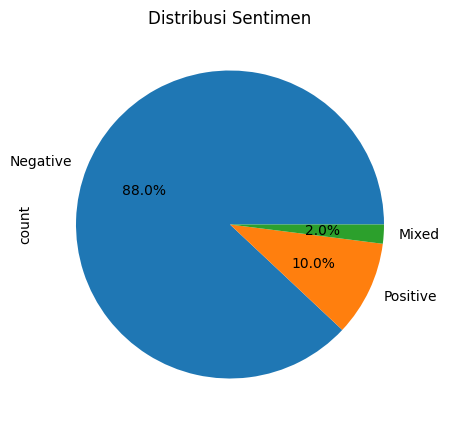

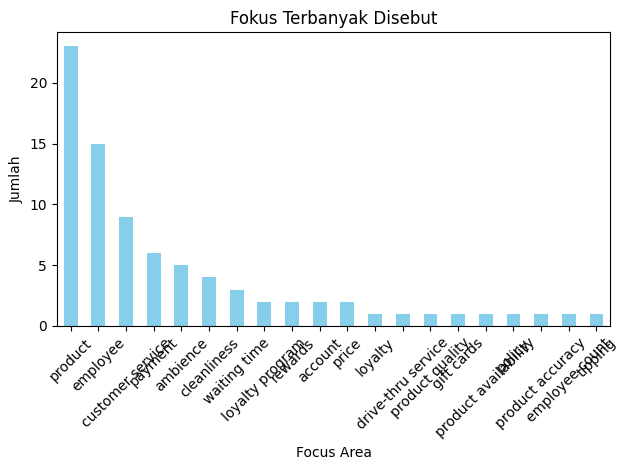

In [ ]:
import matplotlib.pyplot as plt

# Pie Chart Sentimen
df_result['Sentiment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.title("Distribusi Sentimen")
plt.show()

# Bar Chart Fokus
focus_series = pd.Series(all_focus)
focus_series.value_counts().plot.bar(color='skyblue')
plt.title("Fokus Terbanyak Disebut")
plt.xlabel("Focus Area")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
